In [1]:
import requests
import pandas as pd
import json
import numpy as np
from scipy.spatial.distance import cdist
import os
from datetime import timedelta
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, LineString,Point, box
from kloppy import skillcorner
from kloppy.domain import Team
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from urllib.request import urlopen
from highlight_text import fig_text
from matplotlib.animation import FuncAnimation

from PIL import Image

from mplsoccer import PyPizza, add_image, FontManager


# Setup pitch and plot
from mplsoccer import Pitch
#from mplsoccer.pitch import Pitch ,VerticalPitch

# username = "XXX"
# password = "XXX"


# from skillcorner.client import SkillcornerClient
# client=SkillcornerClient(username=username,password=password)

def time_to_seconds(time_str):
    if time_str is None:
        return 90 * 60  # 120 minutes = 7200 seconds
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

font_normal = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Regular.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Italic.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab[wght].ttf')

In [2]:
def load_matches(matches_json_path):

    with open(matches_json_path, "r") as f:
        matches_json = json.load(f)

    match_ids = [match["id"] for match in matches_json]

    all_tracking = []

    for match_id in match_ids:
        tracking_data_github_url = f'https://media.githubusercontent.com/media/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl'
        
        dataset = skillcorner.load(
            meta_data=f'https://raw.githubusercontent.com/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_match.json',
            raw_data=tracking_data_github_url,
            # Optional arguments,
            coordinates="skillcorner",
            include_empty_frames=False)

        all_tracking.append(dataset)

    all_de_dfs = []

    for match_id in match_ids:
        url = f"https://raw.githubusercontent.com/SkillCorner/opendata/master/data/matches/{match_id}/{match_id}_dynamic_events.csv"
        try:
            de_match = pd.read_csv(url)
            all_de_dfs.append(de_match)
        except Exception as e:
            print(f"Failed to load dynamic events for match {match_id}: {e}")

    de_all_matches = pd.concat(all_de_dfs, ignore_index=True)
    
    return all_tracking, de_all_matches
        

In [3]:
# Load matches

matches_json_path = os.path.join(os.path.dirname(os.getcwd()), "data/matches.json")
all_tracking, de_all_matches = load_matches(matches_json_path)

C:\Users\g4a4b\AppData\Local\Temp\ipykernel_11268\822448290.py:27: DtypeWarning: Columns (75,77,184,264) have mixed types. Specify dtype option on import or set low_memory=False.
  de_match = pd.read_csv(url)
C:\Users\g4a4b\AppData\Local\Temp\ipykernel_11268\822448290.py:27: DtypeWarning: Columns (276) have mixed types. Specify dtype option on import or set low_memory=False.
  de_match = pd.read_csv(url)


How can a midfielder create space?
- He moves to another location and his origin location is free.
- Moving to another location creates a pass line.
- Dragging defenders
- pushing defensive line with in behind runs


In [ ]:
def midfielders_obe(de_all_matches):
    # Get off-ball events
    off_ball_events = de_all_matches[de_all_matches["event_type_id"] == 1]

    # Get only off ball events from midfielders
    positions_mid = [9,10,11,12,13,14,15]
    mid_obe = off_ball_events[off_ball_events["player_position_id"].isin(positions_mid)].copy()

    # For every obe, column id equals event_id_match_id
    mid_obe["id"] = mid_obe["event_id"].astype(str) + "_" + mid_obe["match_id"].astype(str)
    mid_obe = mid_obe.reset_index(drop=True)

    # Data matching
    mid_obe = mid_obe[
            (mid_obe["is_player_possession_start_matched"] == True) &
            (mid_obe["is_player_possession_end_matched"] == True)
        ]
    return mid_obe

In [ ]:
def avg_distance(mid_obe, all_tracking):

    for row in mid_obe.itertuples():
        # Find the match in all_tracking
        match = next((m for m in all_tracking if int(m.metadata.game_id) == int(row.match_id)), None)
        if not match:
                raise ValueError(f"Match {row.match_id} not found in all_tracking")
        
        # Find the start frame in the match frames
        start_frame = next((f for f in match.frames if int(f.frame_id) == int(row.frame_start)), None)
        if not start_frame:
            print(f"Start frame {row.frame_start} not found in match {row.match_id}")
            continue  # Skip if start frame not found
        
        end_frame = next((f for f in match.frames if int(f.frame_id) == int(row.frame_end)), None)
        if not end_frame:
            print(f"End frame {row.frame_end} not found in match {row.match_id}")
            continue  # Skip if end frame not found
        
        # Get player coordinates
        player_coord = None
        player_team = None
        for player, coord in start_frame.players_coordinates.items():
            if player.player_id == str(row.player_id):
                player_coord = np.array([coord.x, coord.y])
                player_team = player.team.team_id
                break

        if player_coord is None:
            continue

        # --- Start frame distances ---
        opponents_start = np.array([[c.x, c.y] for p, c in start_frame.players_coordinates.items()
                                    if p.team.team_id != player_team])
        if len(opponents_start) > 0:
            distances_start = cdist([player_coord], opponents_start).flatten()
            close_start = distances_start[distances_start <= 5]
            avg_distance_start = close_start.mean() if len(close_start) > 0 else np.nan
        else:
            avg_distance_start = np.nan

        # --- End frame distances ---
        opponents_end = np.array([[c.x, c.y] for p, c in end_frame.players_coordinates.items()
                                if p.team.team_id != player_team])
        if len(opponents_end) > 0:
            distances_end = cdist([player_coord], opponents_end).flatten()
            close_end = distances_end[distances_end <= 5]
            avg_distance_end = close_end.mean() if len(close_end) > 0 else np.nan
        else:
            avg_distance_end = np.nan

        # Store results in mid_obe DataFrame
        mid_obe.at[row.Index, 'def_density_change'] = avg_distance_end - avg_distance_start
        
    return mid_obe

In [133]:
def get_voronoi_bounded(points, index, pitch_bounds):
    # Add padding points to bound Voronoi
    padding = np.array([
            [-1000, -1000],
            [1000, 1000],
            [1000, -1000],
            [-1000, 1000]
    ])
    points = np.vstack([points, padding])

    # Compute Voronoi
    vor = Voronoi(points)

    # Get region of target player
    region_index = vor.point_region[index]
    region = vor.regions[region_index]

    # Collect finite vertices
    finite_vertices = [vor.vertices[i] for i in region if i != -1]

    poly = Polygon(finite_vertices)

    # Clip with pitch bounds
    poly_clipped = poly.intersection(pitch_bounds)

    if poly_clipped.is_empty:
        raise ValueError("Clipped polygon is empty")

    return poly_clipped

In [153]:
def space_creation(mid_obe, all_tracking):

    mid_obe = mid_obe.reset_index(drop=True)

    pitch_bounds = box(-52.5, -34, 52.5, 34)  # SkillCorner pitch centered at (0,0)


    # Add a column for Voronoi area changes
    mid_obe["voronoi_area_start"] = np.nan
    mid_obe["voronoi_area_end"] = np.nan
    mid_obe["space_created"] = np.nan
    mid_obe["voronoi_poly_start"] = None
    mid_obe["voronoi_poly_end"] = None

    i = 0
    for row in mid_obe.itertuples():
        # Match
        match = next((m for m in all_tracking 
                      if int(m.metadata.game_id) == int(row.match_id)), None)
        if not match:
            raise ValueError(f"Match {row.match_id} not found in all_tracking")
        
        start_frame = next((f for f in match.frames 
                            if int(f.frame_id) == int(row.frame_start)), None)

        end_frame = next((f for f in match.frames 
                          if int(f.frame_id) == int(row.frame_end)), None)
        
        if not start_frame or not end_frame:
            i+=1
            print(f"Missing frame(s) for row {row.Index}")
            continue

        # Get player index + all positions
        players_start = []
        target_idx_start = None

        for idx, (player, coord) in enumerate(start_frame.players_coordinates.items()):
            players_start.append([coord.x, coord.y])
            if player.player_id == str(row.player_id):
                target_idx_start = idx

        players_start = np.array(players_start)

        # 1️⃣ Voronoi at start frame
        poly_start = get_voronoi_bounded(players_start, target_idx_start, pitch_bounds)
        area_start = poly_start.area if poly_start else np.nan

        # 2️⃣ Voronoi at end frame but **at the original start location**
        players_end = []
        for idx, (player, coord) in enumerate(end_frame.players_coordinates.items()):
            if player.player_id == str(row.player_id):
                # use start frame location
                players_end.append(players_start[target_idx_start])
            else:
                players_end.append([coord.x, coord.y])

        players_end = np.array(players_end)

        poly_end = get_voronoi_bounded(players_end, target_idx_start, pitch_bounds)
        area_end = poly_end.area if poly_end else np.nan

        # Store in DataFrame
        mid_obe.at[row.Index, 'voronoi_area_start'] = area_start
        mid_obe.at[row.Index, 'voronoi_area_end'] = area_end
        mid_obe.at[row.Index, 'space_created'] = area_end - area_start
        mid_obe.at[row.Index, 'voronoi_poly_start'] = poly_start
        mid_obe.at[row.Index, 'voronoi_poly_end'] = poly_end
    
    print(f"Skipped {i} rows due to missing frames")

    return mid_obe


In [ ]:
mid_obe = midfielders_obe(de_all_matches)
#mid_obe = avg_distance(mid_obe, all_tracking)
mid_obe = space_creation(mid_obe, all_tracking)

In [156]:
pitch = Pitch(pitch_type="skillcorner",
              pitch_length=105,
              pitch_width=68,
              pitch_color="#001400",
              line_color="white",
              linewidth=1.5)

In [184]:
def plot_voronoi(pitch, mid_obe, all_tracking, frame = "start", idx=121):

    fig, ax = pitch.grid(figheight=8, endnote_height=0, title_height=0)

    # Select the run
    example_poly_start = mid_obe.at[idx, 'voronoi_poly_start']
    example_poly_end = mid_obe.at[idx, 'voronoi_poly_end']

    if frame == "start":
        if example_poly_start:
            x, y = example_poly_start.exterior.xy
            ax.fill(x, y, color='blue', alpha=0.3, label='Start frame')
    else:
        if example_poly_end:
            x, y = example_poly_end.exterior.xy
            ax.fill(x, y, color='red', alpha=0.3, label='End frame')

    # --- Plot all player coordinates ---
    row = mid_obe.iloc[idx]
    player_id = row.player_id
    match = next((m for m in all_tracking if int(m.metadata.game_id) == int(row.match_id)), None)
    start_frame = next((f for f in match.frames if int(f.frame_id) == int(row.frame_start)), None)
    print(f"Start frame ID: {start_frame.frame_id}")
    print(f"Time: {start_frame.timestamp}")
    end_frame = next((f for f in match.frames if int(f.frame_id) == int(row.frame_end)), None)
    print(f"End frame ID: {end_frame.frame_id}")
    print(f"Time: {end_frame.timestamp}")

    for player, coord in start_frame.players_coordinates.items():
        if player.player_id == str(player_id):
            team_id = player.team.team_id
            if frame == "start":
                ax.scatter(coord.x, coord.y, color='yellow', s=50, zorder=5, label='Runner')  # Runner location
            else:
                ax.scatter(coord.x, coord.y, color='blue', s=50, zorder=5, label='Runner')  # Runner location
            break
    if frame == "start":
        for player, coord in start_frame.players_coordinates.items():
            if player.team.team_id == team_id and player.player_id != str(player_id):
                ax.scatter(coord.x, coord.y, color='green', s=50, zorder=5)  # Teammates
            elif player.team.team_id != team_id:
                ax.scatter(coord.x, coord.y, color='red', s=50, zorder=5)    # Opponents
    else:
        for player, coord in end_frame.players_coordinates.items():
            if player.team.team_id == team_id and player.player_id != str(player_id):
                ax.scatter(coord.x, coord.y, color='green', s=50, zorder=5)  # Teammates
            elif player.team.team_id != team_id:
                ax.scatter(coord.x, coord.y, color='red', s=50, zorder=5)    # Opponents
            else:
                ax.scatter(coord.x, coord.y, color='yellow', s=50, zorder=5)  # Runner location
    
    # --- Plot the ball ---
    if frame == "start":
        ball_coord = start_frame.ball_coordinates
    else:
        ball_coord = end_frame.ball_coordinates
    ax.scatter(ball_coord.x, ball_coord.y, color='white', s=30, zorder=5, label='Ball')
        
    # --- 5️⃣ Add legend ---
    ax.legend(loc='upper right')

    plt.show()

Start frame ID: 24001
Time: 0:39:59.100000
End frame ID: 24055
Time: 0:40:04.500000


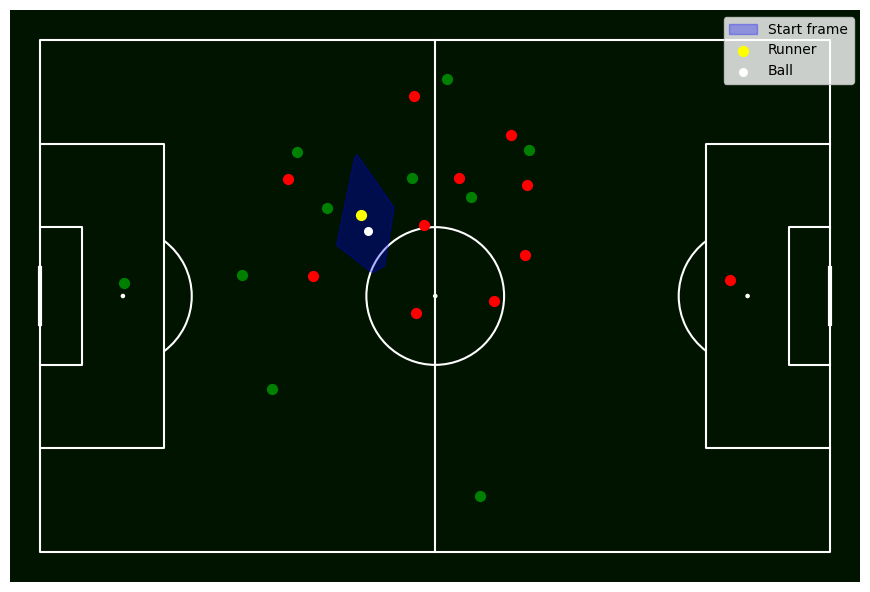

Start frame ID: 24001
Time: 0:39:59.100000
End frame ID: 24055
Time: 0:40:04.500000


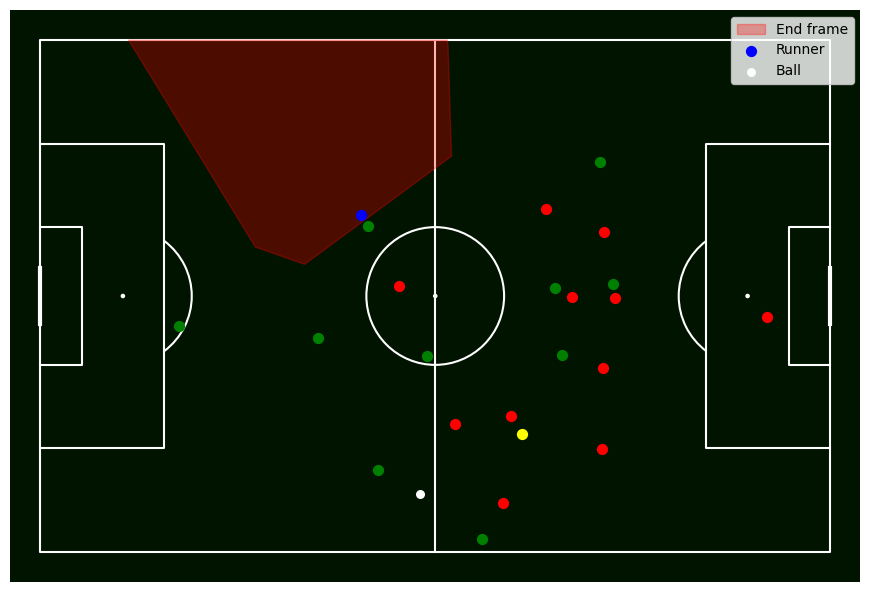

In [192]:
plot_voronoi(pitch, mid_obe, all_tracking, frame="start", idx=1183)
plot_voronoi(pitch, mid_obe, all_tracking, frame="end", idx=1183)

In [190]:
# Find idx where the voronoi_area_end is smaller than voronoi_area_start
smaller_area_idxs = mid_obe[mid_obe['voronoi_area_end'] < mid_obe['voronoi_area_start']].index.tolist()
print("Indices where voronoi_area_end is smaller than voronoi_area_start:", smaller_area_idxs)

# Find top 5 idx where the space_created is maximum
top_5_space_created_idx = mid_obe['space_created'].nlargest(5).index.tolist()
print("Top 5 indices with maximum space created:", top_5_space_created_idx)

Indices where voronoi_area_end is smaller than voronoi_area_start: [4, 6, 7, 8, 10, 12, 13, 14, 22, 24, 26, 27, 28, 29, 32, 33, 37, 38, 40, 41, 50, 52, 54, 59, 62, 64, 68, 69, 70, 71, 73, 74, 75, 76, 78, 79, 80, 81, 82, 84, 85, 86, 90, 92, 95, 100, 102, 104, 107, 109, 112, 113, 115, 117, 119, 120, 121, 126, 127, 132, 133, 134, 135, 136, 137, 140, 142, 143, 146, 149, 151, 152, 154, 157, 158, 163, 166, 168, 170, 171, 176, 177, 180, 181, 182, 186, 187, 188, 190, 193, 196, 197, 204, 206, 209, 210, 212, 213, 215, 218, 222, 223, 225, 226, 227, 230, 232, 235, 239, 240, 243, 244, 245, 248, 249, 252, 253, 255, 260, 261, 262, 264, 268, 270, 272, 273, 274, 275, 278, 280, 281, 288, 289, 290, 292, 294, 295, 299, 303, 304, 306, 308, 310, 311, 314, 315, 316, 317, 318, 323, 324, 326, 327, 329, 330, 335, 337, 339, 341, 344, 345, 349, 354, 355, 356, 359, 361, 362, 364, 365, 369, 372, 376, 377, 378, 379, 380, 381, 384, 388, 390, 396, 397, 398, 404, 407, 411, 412, 414, 417, 419, 420, 424, 430, 433, 435, 4

In [ ]:
# Filter by runs with duration less than 5 seconds
# Get the area in the start and after 1,2 and 3 seconds and get the maximum


# Space created per player per90min

# Get the total minutes played through all the matches per player
# Get the total space created through all the matches per player